# A simple tailoring model from scratch

In [1]:
import os
import pandas as pd
import numpy as np

import re
import string
from autocorrect import Speller
spell = Speller(lang='en')

punctuations = list(string.punctuation)
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
lemm = WordNetLemmatizer()
from nltk.stem import PorterStemmer
ps = PorterStemmer()

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.pipeline import make_pipeline


#gradient boost
from catboost import CatBoostClassifier

#naive bayes classification
from nltk import FreqDist
from nltk.classify import NaiveBayesClassifier,accuracy
import nltk.classify.util as util
from nltk.sentiment import SentimentAnalyzer
from nltk.collocations import BigramCollocationFinder as BCF
from nltk.metrics import BigramAssocMeasures
import itertools

from sklearn.metrics import confusion_matrix,accuracy_score,classification_report,plot_confusion_matrix

## Importing the Dataset

In [3]:
inputWD = os. getcwd() +'\\input\\'
path = os. getcwd() +'\\outputs\\'
file = 'selected_tweets1600.csv'
result_file = 'azure_sentiment.csv'
#load the source file
df_tweet = pd.read_csv(path+file, sep=',')
df_sentiment = pd.read_csv(path+result_file, sep=',', index_col=0)
tweets = list(df_tweet.tweet)

In [4]:
df_tweet.polarity.value_counts()

0    811
4    789
Name: polarity, dtype: int64

In [5]:
df_sentiment.sentiment.value_counts()

positive    621
negative    450
neutral     408
mixed       121
Name: sentiment, dtype: int64

## Text Preprocessing

1. text cleaning

In [6]:
#Fixing Word Lengthening
def reduce_lengthening(text):
    pattern = re.compile(r"(.)\1{2,}")
    return pattern.sub(r"\1\1", text)

def text_preprocess(doc):
    #Lowercasing all the letters
    temp = doc.lower()
    #Removing hashtags and mentions
    temp = re.sub("@[A-Za-z0-9_]+","", temp)
    temp = re.sub("#[A-Za-z0-9_]+","", temp)
    #Removing links
    temp = re.sub(r"http\S+", "", temp)
    temp = re.sub(r"www.\S+", "", temp)
    #removing numbers
    temp = re.sub("[0-9]","", temp)
    #Removing '
    temp = re.sub("'"," ",temp)

    #Tokenization
    temp = word_tokenize(temp)
    #Removing punctuations
    temp = [w for w in temp if not w in punctuations]
    #Fixing Word Lengthening
    temp = [reduce_lengthening(w) for w in temp]
    #spell corrector
    temp = [spell(w) for w in temp]
    #stem
    temp = [ps.stem(w) for w in temp]
    #Removing short words
    temp = [w for w in temp if len(w)>1]
    temp = " ".join(w for w in temp)
    
    return temp


In [7]:
%%time
#text cleaning
cleaned_tweets = [text_preprocess(d) for d in tweets] 
print(cleaned_tweets[:3])

['want to compet want hard competit want to ralli want to feel the power come out of the engin want to compet', 'it seem we are stuck on the ground in armadillo they have put ground stop for all flight leav for denver said updat in an hour', 'where the are my link hear rarararrarararr .. babyproof while cut stuff make me stick hear random place amp forget them']
CPU times: total: 42.2 s
Wall time: 59.1 s


In [8]:
#check if empty elements in the list
for i in range(len(cleaned_tweets)):
    if cleaned_tweets[i] =='':
        print('The tweet #%s "%s" is empty after the cleaning operation, and replaced by the word "empty".' % (str(i), tweets[i]))
        cleaned_tweets[i]="empty"

The tweet #1240 "@russians_in_uk ?? ?? ??: ?????????? ??????? ??????, ??? ????????????! " is empty after the cleaning operation, and replaced by the word "empty".
The tweet #1426 "@vexedinthecity  http://bit.ly/wdqfO" is empty after the cleaning operation, and replaced by the word "empty".


## Splitting the data

In [9]:
#replacing textual categories by integers
X = cleaned_tweets
"""
di = {"positive": 3, "neutral": 2, "mixed": 1, "negative":0 }
class_name = ['negative', 'mixed','neutral','positive']
y = df_sentiment['sentiment'].replace(di)

"""
class_names = ['negative', 'positive']
y = df_tweet.polarity.values

#split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print("training size:", len(X_train))
print("testing size:", len(X_test))

training size: 1120
testing size: 480


## Building a gradient boosting model


1. Vertorizing

In [10]:
pipe = make_pipeline(CountVectorizer(), TfidfTransformer())
pipe.fit(X_train)

Xtrain = pipe.transform(X_train)
Xtest = pipe.transform(X_test)
print("training dataset size:", Xtrain.shape)
print("test dataset size:", Xtest.shape)

training dataset size: (1120, 2485)
test dataset size: (480, 2485)


2. Building a catboost model

In [11]:
%%time

cat_classifier = CatBoostClassifier(iterations=300,
                         learning_rate=0.001,
                         depth=8,
                         eval_metric='CrossEntropy',
                         od_type='Iter',
                         od_wait=20,
                         silent=True
                        )
#Evaluate model
scores = cross_validate(cat_classifier, Xtrain, y_train, scoring='accuracy', cv=5)
#Get average evaluation metrics
print('Mean accuracy: %.3f' % scores['test_score'].mean())

cat_classifier.fit(Xtrain, y_train,eval_set=(Xtest, y_test),plot=True);

Mean accuracy: 0.627


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CPU times: total: 3min 23s
Wall time: 1min 56s


3. evaluation

In [13]:
#prediction
predictions = cat_classifier.predict(Xtest)

print('Test score: %.2f\n' % (accuracy_score(y_test, predictions)))
# Classification report for Classifier
print("Classification report for Classifier: \n\n%s: \n\n %s" % (cat_classifier,
                                                                 classification_report(y_test,
                                                                                       predictions)))

Test score: 0.65

Classification report for Classifier: 

<catboost.core.CatBoostClassifier object at 0x000001B5B4D6F5E0>: 

               precision    recall  f1-score   support

           0       0.61      0.81      0.70       242
           4       0.72      0.48      0.57       238

    accuracy                           0.65       480
   macro avg       0.67      0.65      0.64       480
weighted avg       0.66      0.65      0.64       480



<AxesSubplot:>

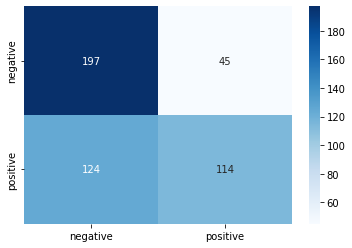

In [14]:
#generate a confusion matrix
conf_mat = confusion_matrix(y_test, predictions)
df_cm = pd.DataFrame(conf_mat, index = class_names, columns = class_names)

#plotting
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues",fmt=".0f")


## Using Nltk nativebayes classification

1. build the features from training set

In [15]:
def build_dataset(X,y):
    #build the dataset
    words = [words.split(" ") for words in X]
    dataset = list(zip(words, y))
    
    return dataset

trainset = build_dataset(X_train, y_train)
testset = build_dataset(X_test, y_test)

In [16]:
# Define the feature extractor
all_words = FreqDist(sum([w.split(" ") for w in X_train],[]))
word_features = list(all_words)[:2000]
    
def document_features(words):
    features = {}
    for word in word_features:
        features['contains({})'.format(word)] = (word in set(words))

    return features

In [17]:
train_set = [(document_features(d), y) for (d,y) in trainset]
test_set = [(document_features(d), y) for (d,y) in testset]

2. training the classifier

In [18]:
# Train Naive Bayes classifier
#training
classifier = NaiveBayesClassifier.train(train_set)

3. evaluation

In [19]:
# Test the classifier
print("accuracy score on test set:", accuracy(classifier, test_set))

accuracy score on test set: 0.68125


In [20]:
# Show the most important features as interpreted by Naive Bayes
classifier.show_most_informative_features(5)

Most Informative Features
          contains(didn) = True                0 : 4      =      6.8 : 1.0
          contains(wish) = True                0 : 4      =      6.0 : 1.0
         contains(those) = True                4 : 0      =      5.9 : 1.0
          contains(suck) = True                0 : 4      =      5.5 : 1.0
          contains(miss) = True                0 : 4      =      5.4 : 1.0


<AxesSubplot:>

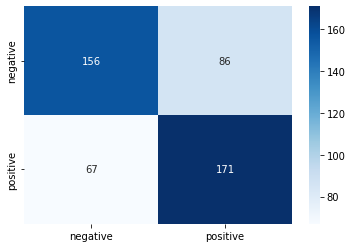

In [21]:
#prediction
predictions=[]
for (features,y) in test_set:
    pred = classifier.classify(features)
    predictions.append(pred)

#generate a confusion matrix
conf_mat = confusion_matrix(y_test, predictions)
df_cm = pd.DataFrame(conf_mat, index = class_names, columns = class_names)

#plotting
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues",fmt=".0f")